# ST446 Distributed Computing for Big Data
## Seminar class 8: scalable machine learning II
---

## Topic modeling: Latent Semantic Analysis

In the lectures, we learned two methods for topic modeling: Latent Semantic Analysis (LSA) and Latent Dirichlet Allocation (LDA).
In this notebook, we demonstrate how to do topic modelling for a document corpus in PySpark using LSA. 

We show how to:
* tokenize and lemmatize textual data using the natural language tool kit (NLTK)
* convert words and documents into vector representations, specially, the use of sparse vectors
* the use of LSA (SVD) to infer the vector representations (referred to as *latent factors*)
* visualize the latent factors using t-SNE

We recommend running this notebook on a dataproc cluster.

## Recap

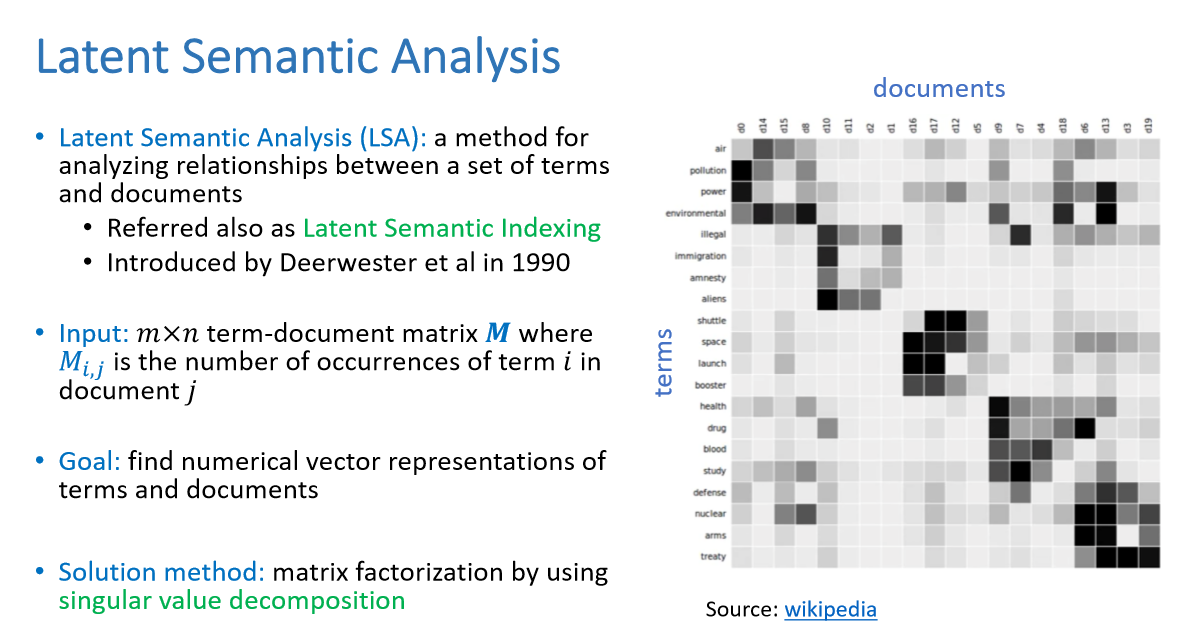

In [1]:
# To display these images in Google Colab you should i) upload all PNG files to your Google Colab
# folder and ii) adjust the path (eg /content/sample_data)
from IPython.display import Image
Image(filename='./LSA-1.png')

## Load data

In [ ]:
# you should not need these commands on a correctly initialised cluster:
# # run this command in a terminal, if sklearn is not installed on your machine/compute engine:
# pip install -U scikit-learn

# # run this command in a terminal, if nltk is not installed on your machine/compute engine:
# pip install -U nltk

# # to get the stopwords dataset, use python
# >>> import nltk
# >>> nltk.download('stopwords')

In [ ]:
import nltk # test
nltk.download('all') # uncomment this for the first to check that all data has already been nstalled
sc.defaultParallelism
# note that this should ouput "already up-to-date!" for every package!

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package cess_cat is already up-

4

We are downloading the standard data set 20 newsgroup, see https://scikit-learn.org/stable/datasets/index.html#newsgroups-dataset

In [ ]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

documents = dataset.data

news = sc.parallelize(documents)
news.take(2)

['I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.',
 "A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't an

In [ ]:
print('Number of partitions: ', news.getNumPartitions())
n = news.count()
print('Number of messages/documents n = ', n)

Number of partitions:  4
Number of messages/documents D =  11314


## 1. Parse the data

Here we make use of the natural language processing module `nltk`. 

Both the module and the corresponding data should have been downloaded by our custom cluster initialisation actions. See https://www.nltk.org/install.html and https://www.nltk.org/data.html for more details.

We will have to process the messages to make them amenable to analysis. Important steps include:
* Tokenisation chops text into useful units (words). 
* Lemmatisation groups together inflected words, yields their dictionary form.

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop_words = set(stopwords.words('english'))
table = str.maketrans('', '', string.punctuation)
lmtzr = WordNetLemmatizer() # see https://www.nltk.org/_modules/nltk/stem/wordnet.html for details

def get_tokens(line):
    ###
    import nltk
#     nltk.download('all')
    ###
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuations from each word
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    # lemmatizing the words, see https://en.wikipedia.org/wiki/Lemmatisation
    words = [lmtzr.lemmatize(w) for w in words]
    return (words)

news_rdd = news.map(lambda line: (1, get_tokens(line)))
news_rdd.take(1)

[(1,
  ['wondering',
   'anyone',
   'could',
   'enlighten',
   'car',
   'saw',
   'day',
   'sport',
   'car',
   'looked',
   'late',
   'early',
   'called',
   'bricklin',
   'door',
   'really',
   'small',
   'addition',
   'front',
   'bumper',
   'separate',
   'rest',
   'body',
   'know',
   'anyone',
   'tellme',
   'model',
   'name',
   'engine',
   'spec',
   'year',
   'production',
   'car',
   'made',
   'history',
   'whatever',
   'info',
   'funky',
   'looking',
   'car',
   'please',
   'email'])]

**Question**: why we add a key of `1` to all the rows?

Some of the stop words are content specific (https://en.wikipedia.org/wiki/Stop_words). Here we assume that words that appear very frequently are stop words. We use 3000 as a threshold.

In [ ]:
doc_stop_words = news_rdd.flatMap(lambda r: r[1]).map(lambda r: (r,1)).reduceByKey(lambda a,b: a+b)

# doc_stop_words.collect()

doc_stop_words = doc_stop_words.filter(lambda a: a[1]>3000).map(lambda r: r[0]).collect()

# throw away stop words and words that are just single letters.
news_rdd = news_rdd.map(lambda r: (r[0],[w for w in r[1] if not w in doc_stop_words and not len(w)==1]))    

news_rdd.take(1)[0][1][:10]

['wondering',
 'anyone',
 'could',
 'enlighten',
 'car',
 'saw',
 'day',
 'sport',
 'car',
 'looked']

## 2. Convert tokens into sparse vectors

In [ ]:
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import monotonically_increasing_id

news_df = spark.createDataFrame(news_rdd, ["dummy","words"])
news_df.cache()
news_df.take(1)

[Row(dummy=1, words=['wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'sport', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'door', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'anyone', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please', 'email'])]

Now, we generate vectors that are essentially historgrams of word counts associated with each message, see https://spark.apache.org/docs/latest/ml-features.html#countvectorizer

In [ ]:
cv = CountVectorizer(inputCol="words", outputCol="features", minDF=2)

cv_model = cv.fit(news_df)

news_df_w_features = cv_model.transform(news_df)
news_df_w_features.cache()
news_df_w_features.show(10)

+-----+--------------------+--------------------+
|dummy|               words|            features|
+-----+--------------------+--------------------+
|    1|[wondering, anyon...|(30870,[0,1,32,37...|
|    1|[fair, number, br...|(30870,[18,29,37,...|
|    1|[well, folk, mac,...|(30870,[0,3,4,7,9...|
|    1|[weitek, addressp...|(30870,[29,38,118...|
|    1|[article, worldst...|(30870,[2,3,11,13...|
|    1|[course, term, mu...|(30870,[16,31,40,...|
|    1|[responded, reque...|(30870,[0,6,61,62...|
|    1|[show, much, scsi...|(30870,[8,9,10,11...|
|    1|[win, downloaded,...|(30870,[56,60,146...|
|    1|[board, year, wor...|(30870,[1,4,5,6,1...|
+-----+--------------------+--------------------+
only showing top 10 rows



### Convert pyspark.ml vectors to pyspark.mllib vectors

This will make it possible to appy spark's sparse SVD algorithm.

In [ ]:
from pyspark.mllib.linalg import Vectors
#from pyspark.ml import linalg as ml_linalg
def as_mllib_vector(v):
    return Vectors.sparse(v.size, v.indices, v.values)

features = news_df_w_features.select("features")
feature_vec = features.rdd.map(lambda r: as_mllib_vector(r[0]))

feature_vec.cache()
feature_vec.take(1)

[SparseVector(30870, {0: 1.0, 1: 1.0, 32: 2.0, 37: 1.0, 43: 1.0, 52: 1.0, 63: 1.0, 72: 1.0, 85: 1.0, 91: 4.0, 149: 1.0, 186: 1.0, 229: 1.0, 242: 1.0, 294: 1.0, 322: 1.0, 331: 1.0, 411: 1.0, 488: 1.0, 534: 1.0, 554: 1.0, 588: 1.0, 604: 1.0, 755: 1.0, 764: 1.0, 788: 1.0, 936: 1.0, 1047: 1.0, 1218: 1.0, 1366: 1.0, 1499: 1.0, 2061: 1.0, 5623: 1.0, 8868: 1.0, 15717: 1.0, 26974: 1.0})]

### Take a look at the vocabulary
The cv model stores the vocabulary separately from the histograms of words for each document.

In [ ]:
print ("Vocabulary from CountVectorizerModel is:")
print(cv_model.vocabulary[:100])
print("\n---\n")

m = len(cv_model.vocabulary)
print("Number of terms m = ", m)

Vocabulary from CountVectorizerModel is:
['could', 'year', 'system', 'new', 'make', 'say', 'file', 'good', 'may', 'well', 'problem', 'right', 'even', 'thing', 'way', 'see', 'first', 'work', 'two', 'much', 'many', 'god', 'want', 'need', 'program', 'go', 'used', 'window', 'said', 'number', 'question', 'point', 'anyone', 'something', 'take', 'come', 'since', 'please', 'information', 'drive', 'using', 'key', 'back', 'really', 'state', 'mean', 'going', 'look', 'still', 'part', 'find', 'case', 'day', 'game', 'believe', 'must', 'help', 'government', 'available', 'law', 'ca', 'last', 'thanks', 'email', 'might', 'another', 'run', 'data', 'group', 'got', 'without', 'line', 'made', 'let', 'better', 'sure', 'etc', 'read', 'give', 'never', 'set', 'space', 'fact', 'lot', 'power', 'name', 'however', 'armenian', 'card', 'support', 'list', 'car', 'version', 'around', 'tell', 'team', 'second', 'probably', 'someone', 'world']

---

Number of terms W =  30870


## 3. Latent Semantic Analysis 

Latent Semantic Analysis is based on computing a SVD of the term-document matrix and using the left singular vectors and the right singular vectors as latent factor loadings to represent terms and documents, respectively. 

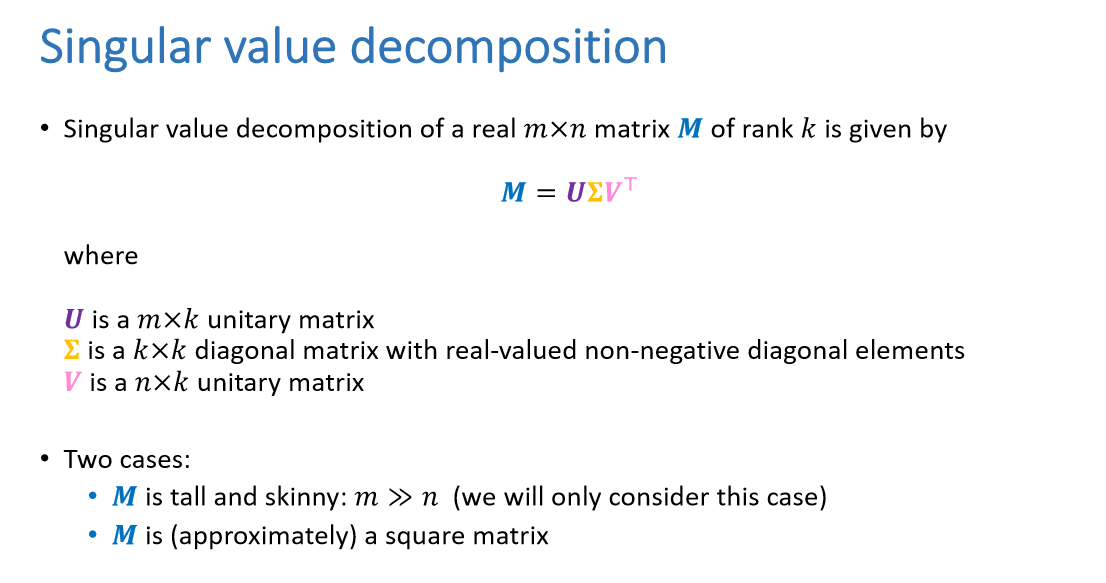

In [2]:
from IPython.display import Image
Image(filename='./LSA-2.png')

In [ ]:
from pyspark.mllib.linalg.distributed import RowMatrix

feature_mat = RowMatrix(feature_vec)

# Here we use the dimension of latent factors to be k
k = 5
feature_svd = feature_mat.computeSVD(5, computeU=True)

U = feature_svd.U       # The U factor is a RowMatrix.
s = feature_svd.s       # The singular values are stored in a local dense vector.
V = feature_svd.V       # The V factor is a local dense matrix.

In [ ]:
print("number of rows of U", U.numRows()) # this is the number of documents (D)
print("number of rows of V", V.numRows ) # this is the number of terms (W)

number of rows of U 11314
number of rows of V 30870


In [ ]:
collected = U.rows.take(10)

print("U factors are:")
for vector in collected:
    print(vector)
    
print("Singular values are: \n", s)

print("V factors are: \n", V)

U factors are:
[-0.0011222896971468748,9.074915750521613e-05,0.0013061225767299644,0.0008088746376908758,0.00120377415622899]
[-0.0011694011471896353,-0.00011481625286131677,0.0008851691511401929,-0.00047528219268101784,0.0009687212064435996]
[-0.003720979830136292,0.00012815750515389164,0.0035488849964112118,-4.0156549815082805e-05,0.002165356115857933]
[-0.0003100300940596765,2.1727460750699164e-05,2.9641225981863423e-06,-0.0001335013676674993,0.0001921921400132234]
[-0.001341777912086946,6.352096419659816e-05,0.0007966252428018705,-0.0007076921880897432,0.000520350277454275]
[-0.0011650082845305577,6.77286333447194e-05,0.0008237554193222443,0.0004060959173700004,0.0005085188927193095]
[-0.001198586529879083,9.730402929758209e-05,-0.0004904789481020446,0.0007350309163589522,-0.0003312533940456772]
[-0.0034580908621426256,0.00021967444034126006,0.0020147069884526077,-0.0038350487528484188,0.001346006078110338]
[-0.0002792206753661284,2.3649857448158896e-05,0.00019712111806297495,-0.00

## 4. Visualization of the latent vectors

Let's try to use embed the messages into a 2D space using t-SNE (http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)

Intuitively, you can think of t-SNE as an iterative scheme that walks down the gradient of a function. This function is constructed such that it penalises when similar (in the sense of in a high dimensional space) points are far apart or dissimilar points close together (in a low- dimensional, here 2D, space).

We can think of the rows of $U$ as projections of documents/messages into a $k$-dimensional space determined by the most important topics. This was a form of dimensionality reduction.

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

collected = U.rows.collect()
Uarray = np.array([[x[i] for i in range(k)] for x in collected]) # unpack strange spark vectors
t_sne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='random')
Uembedded = t_sne_model.fit_transform(Uarray)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11314 samples in 0.009s...
[t-SNE] Computed neighbors for 11314 samples in 0.640s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11314
[t-SNE] Computed conditional probabilities for sample 2000 / 11314
[t-SNE] Computed conditional probabilities for sample 3000 / 11314
[t-SNE] Computed conditional probabilities for sample 4000 / 11314
[t-SNE] Computed conditional probabilities for sample 5000 / 11314
[t-SNE] Computed conditional probabilities for sample 6000 / 11314
[t-SNE] Computed conditional probabilities for sample 7000 / 11314
[t-SNE] Computed conditional probabilities for sample 8000 / 11314
[t-SNE] Computed conditional probabilities for sample 9000 / 11314
[t-SNE] Computed conditional probabilities for sample 10000 / 11314
[t-SNE] Computed conditional probabilities for sample 11000 / 11314
[t-SNE] Computed conditional probabilities for sample 11314 / 11314
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence

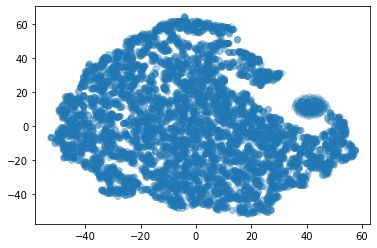

(11314, 2)

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.scatter(Uembedded[:,0],Uembedded[:,1],alpha=.2)
plt.show()
np.shape(Uembedded)

Apparently, this has helped clustering our messages a into sub-structures with related topics.

This is due to the contribution of topics to different messages, as seen when plotting the columns of $U$ against each other. Often, few messages account for a large fraction of variability.

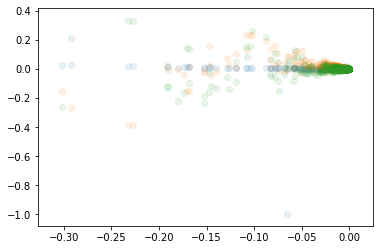

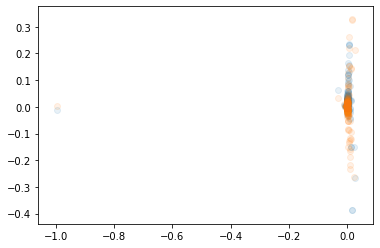

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.scatter(Uarray[:,0],Uarray[:,1],alpha=.1)
plt.scatter(Uarray[:,0],Uarray[:,2],alpha=.1)
plt.scatter(Uarray[:,0],Uarray[:,3],alpha=.1)
plt.show()
plt.scatter(Uarray[:,1],Uarray[:,2],alpha=.1)
plt.scatter(Uarray[:,1],Uarray[:,3],alpha=.1)
plt.show()

## 3b. Latent Dirichlet Allocation

We now analyse the same dataset using Latent Dirichlet Allocation (http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf, https://spark.apache.org/docs/2.2.0/mllib-clustering.html#latent-dirichlet-allocation-lda) to find feature vectors characterizing topics of documents, and feature vectors characterizing the words of topics.

Note that we assume the number of topics $k$ **a priori** (hyperparameter). Here we fix $k=20$

In [ ]:
from pyspark.ml.clustering import LDA

lda = LDA(k=20, maxIter=5)

lda_model = lda.fit(news_df_w_features)

The perplexity below is a measurement of how well a probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample.
You can think of it as being something like $2^{-\frac{1}{N}\sum_i \log_2q(x_i)}$, where $q$ is the model for the probability and the sum goes over $N$ test samples.  It is mainly used when comparing different models.

In [ ]:
ll = lda_model.logLikelihood(news_df_w_features)

lp = lda_model.logPerplexity(news_df_w_features)

print("The lower bound on the log likelihood of the entire corpus: " + str(ll))

print("The upper bound on the perplexity: " + str(lp))

The lower bound on the log likelihood of the entire corpus: -9682969.181927456
The upper bound on the perplexity: 9.905941370671831


In [ ]:
# Describe topics
topics = lda_model.describeTopics(5)

print("The topics described by their top-weighted terms:")

topics.show(truncate=False)

# Shows the results
import numpy as np
topic_i = topics.select("termIndices").rdd.map(lambda r: r[0]).collect()
for i in topic_i:
    print(np.array(cv_model.vocabulary)[i])

The topics described by their top-weighted terms:
+-----+------------------------------+------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                   |termWeights                                                                                                       |
+-----+------------------------------+------------------------------------------------------------------------------------------------------------------+
|0    |[1, 347, 623, 7, 110]         |[5.581572208302464E-4, 2.9462369414069695E-4, 2.874128968986291E-4, 2.6871777255544645E-4, 2.61645309130362E-4]   |
|1    |[2886, 574, 438, 241, 39]     |[2.670070751286365E-4, 2.422782079025227E-4, 1.849619767896665E-4, 1.6375477743704923E-4, 1.6139095176942827E-4]  |
|2    |[249, 24, 6, 869, 5673]       |[7.040687490599862E-4, 3.5595324321367034E-4, 3.076650601965969E-4, 2.7509053888566767E-4, 2.5447896232186617E-4] |
|3    |[710, 0, 66, 7666, 

**Homework: Can you use the output of LDA to embed the messages in 2D space (see scatterplot above)?**